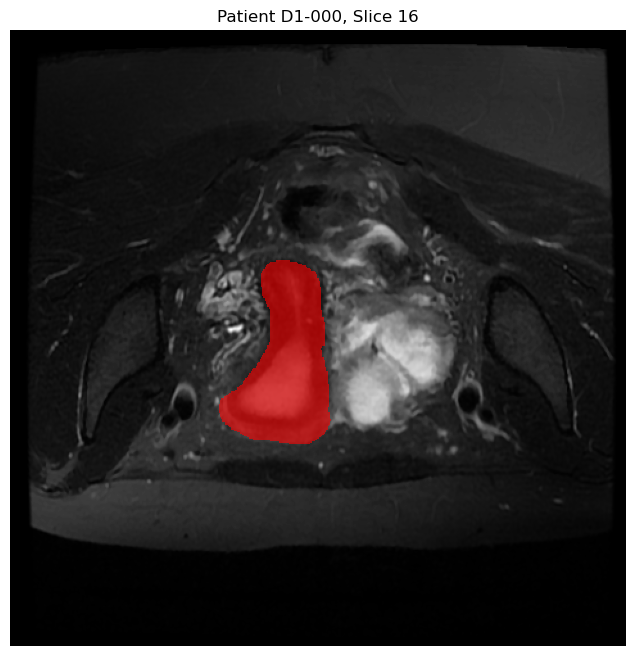

In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the path to the data, going up one directory level first
data_root = '../data/UT-EndoMRI'
patient_id = 'D1-000'
patient_path = os.path.join(data_root, 'D1_MHS', patient_id)

# Construct file paths for the MRI scan and the segmentation mask
mri_path = os.path.join(patient_path, f'{patient_id}_T2.nii.gz')
mask_path = os.path.join(patient_path, f'{patient_id}_ut_r1.nii.gz')

# Load the NIfTI files using SimpleITK
mri_image = sitk.ReadImage(mri_path)
mask_image = sitk.ReadImage(mask_path)

# Convert the SimpleITK images to NumPy arrays to work with them
mri_array = sitk.GetArrayFromImage(mri_image)
mask_array = sitk.GetArrayFromImage(mask_image)

# The data is in (depth, height, width) format. Let's pick a slice from the middle.
slice_index = mri_array.shape[0] // 2
mri_slice = mri_array[slice_index, :, :]
mask_slice = mask_array[slice_index, :, :]

# Create a masked version of the segmentation for overlaying
# This makes the zero-values in the mask transparent
masked_slice = np.ma.masked_where(mask_slice == 0, mask_slice)

# Display the images
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(mri_slice, cmap='gray')
ax.imshow(masked_slice, cmap='autumn', alpha=0.6)
ax.set_title(f'Patient {patient_id}, Slice {slice_index}')
ax.axis('off')
plt.show()

In [3]:
# Cell 2: Dataset Overview

data_root = '../data/UT-EndoMRI'
d1_path = os.path.join(data_root, 'D1_MHS')
d2_path = os.path.join(data_root, 'D2_TCPW')

d1_patients = sorted([p for p in os.listdir(d1_path) if os.path.isdir(os.path.join(d1_path, p))])
d2_patients = sorted([p for p in os.listdir(d2_path) if os.path.isdir(os.path.join(d2_path, p))])

print(f"Found {len(d1_patients)} patients in D1_MHS.")
print(f"First 5 patients in D1: {d1_patients[:5]}\n")

print(f"Found {len(d2_patients)} patients in D2_TCPW.")
print(f"First 5 patients in D2: {d2_patients[:5]}")

Found 51 patients in D1_MHS.
First 5 patients in D1: ['D1-000', 'D1-001', 'D1-002', 'D1-003', 'D1-004']

Found 73 patients in D2_TCPW.
First 5 patients in D2: ['D2-000', 'D2-001', 'D2-002', 'D2-003', 'D2-004']


MHS vs. TCPW

The D1_MHS and D2_TCPW folders correspond to the two different hospitals where the data was collected: Memorial Hermann Hospital System (MHS) and Texas Children’s Hospital Pavilion for Women (TCPW).

Analogy: Think of it like getting photos from two different photographers. Even if they're shooting the same subject, they might use different cameras, lenses, and lighting. The result is that the pictures will have slightly different characteristics. For us, this means the MRI scans from MHS might have different resolutions, noise levels, or dimensions than the ones from TCPW. Our model will need to be robust enough to handle these variations.

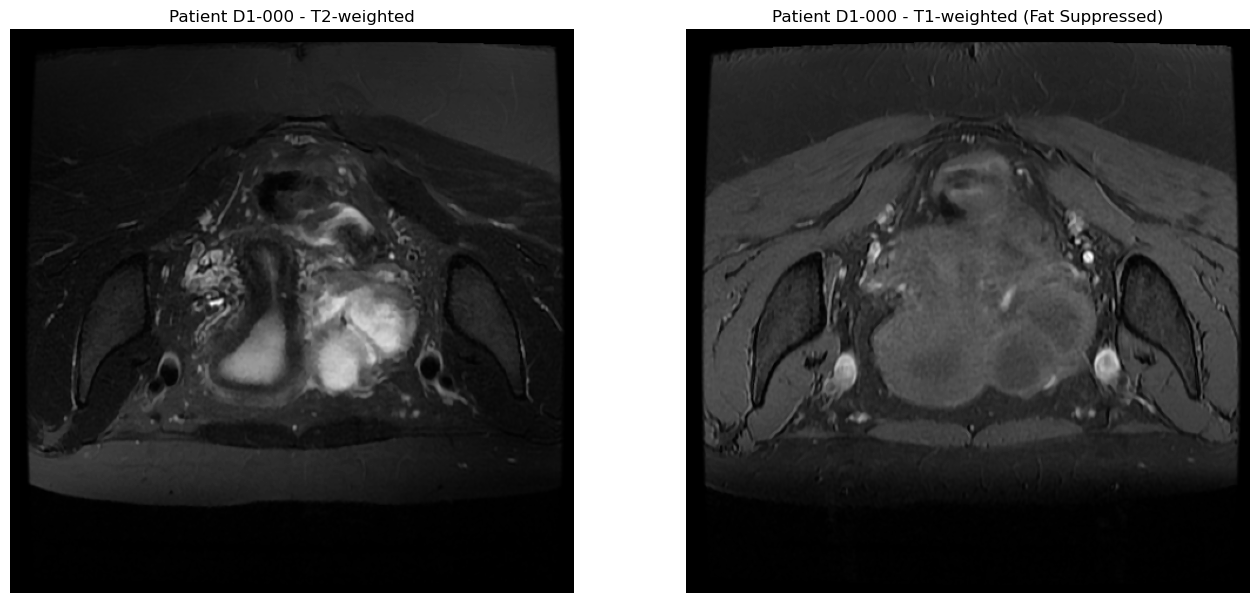

In [4]:
# Cell 3: Compare MRI Modalities for Patient D1-000

patient_id = 'D1-000'
patient_path = os.path.join(data_root, 'D1_MHS', patient_id)

# Paths for T2 and T1 Fat-Suppressed scans
t2_path = os.path.join(patient_path, f'{patient_id}_T2.nii.gz')
t1fs_path = os.path.join(patient_path, f'{patient_id}_T1FS.nii.gz')

# Load images
t2_image = sitk.ReadImage(t2_path)
t1fs_image = sitk.ReadImage(t1fs_path)

# Convert to NumPy arrays
t2_array = sitk.GetArrayFromImage(t2_image)
t1fs_array = sitk.GetArrayFromImage(t1fs_image)

# Get the same middle slice
slice_index = t2_array.shape[0] // 2
t2_slice = t2_array[slice_index, :, :]
t1fs_slice = t1fs_array[slice_index, :, :]

# Display side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(t2_slice, cmap='gray')
ax1.set_title(f'Patient {patient_id} - T2-weighted')
ax1.axis('off')

ax2.imshow(t1fs_slice, cmap='gray')
ax2.set_title(f'Patient {patient_id} - T1-weighted (Fat Suppressed)')
ax2.axis('off')

plt.show()

MRI Modalities

MRI isn't just one type of scan. By changing the settings on the machine, doctors can highlight different types of tissue. These different "settings" are called modalities or sequences. The most common are T1-weighted and T2-weighted.

    T2-weighted (T2): In these scans, water and fluid appear bright. This is great for spotting things like cysts or inflammation.

    T1-weighted (T1): In these, fat appears bright, which is good for seeing the general anatomy.

    Fat Suppressed (FS): This is an extra trick applied to a T1 or T2 scan to make the fat tissue appear dark. This can make it easier to see abnormal tissues that might otherwise be hidden.

Analogy: Think of MRI modalities like different filters on your phone's camera. A "black and white" filter highlights shapes and contrast, while a "vivid color" filter makes certain features pop. Doctors use different MRI modalities to "filter" the image to see specific tissues more clearly.

We only displayed two modalities to keep the example simple, but a patient folder can contain several.

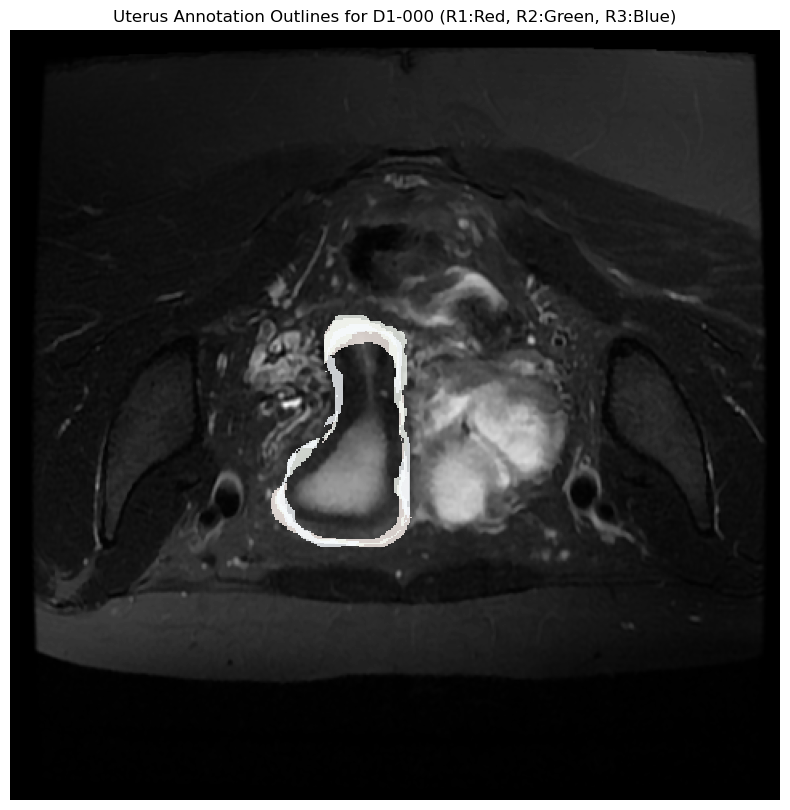

In [8]:
# Cell 4 (Corrected Version): Compare Rater Annotations for Patient D1-000

# Paths to the three rater masks for the uterus
mask_r1_path = os.path.join(patient_path, f'{patient_id}_ut_r1.nii.gz')
mask_r2_path = os.path.join(patient_path, f'{patient_id}_ut_r2.nii.gz')
mask_r3_path = os.path.join(patient_path, f'{patient_id}_ut_r3.nii.gz')

# Load masks
mask_r1_img = sitk.ReadImage(mask_r1_path)
mask_r2_img = sitk.ReadImage(mask_r2_path)
mask_r3_img = sitk.ReadImage(mask_r3_path)

# --- FIX IS HERE ---
# Cast images to an integer type before finding the contour
caster = sitk.CastImageFilter()
caster.SetOutputPixelType(sitk.sitkUInt8)
mask_r1_img = caster.Execute(mask_r1_img)
mask_r2_img = caster.Execute(mask_r2_img)
mask_r3_img = caster.Execute(mask_r3_img)
# --- END FIX ---

# Get the contour (outline) of each mask
contour_r1 = sitk.GetArrayFromImage(sitk.BinaryContour(mask_r1_img, fullyConnected=True))[slice_index, :, :]
contour_r2 = sitk.GetArrayFromImage(sitk.BinaryContour(mask_r2_img, fullyConnected=True))[slice_index, :, :]
contour_r3 = sitk.GetArrayFromImage(sitk.BinaryContour(mask_r3_img, fullyConnected=True))[slice_index, :, :]

# Mask the contours for transparent overlay
masked_contour_r1 = np.ma.masked_where(contour_r1 == 0, contour_r1)
masked_contour_r2 = np.ma.masked_where(contour_r2 == 0, contour_r2)
masked_contour_r3 = np.ma.masked_where(contour_r3 == 0, contour_r3)

# Display the overlays on the T2 image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(t2_slice, cmap='gray')
ax.imshow(masked_contour_r1, cmap='Reds', alpha=0.8)
ax.imshow(masked_contour_r2, cmap='Greens', alpha=0.8)
ax.imshow(masked_contour_r3, cmap='Blues', alpha=0.8)
ax.set_title(f'Uterus Annotation Outlines for {patient_id} (R1:Red, R2:Green, R3:Blue)')
ax.axis('off')
plt.show()

Raters and Annotations

Raters are the human experts (like radiologists) who manually created the ground truth segmentations. They looked at the MRI scans and "painted" the regions corresponding to the different organs.

How annotations are stored: The segmentation is not a list of coordinates. It's actually a separate image file with the exact same dimensions as the MRI scan. In this mask image, every pixel has a value. For example, a pixel value of 1 means "this pixel is part of the uterus," and a pixel value of 0 means "this is not part of the uterus."

Analogy: It's like taking a photograph (the MRI) and placing a clear plastic sheet over it. You then use a red marker to carefully trace and color in the uterus. That plastic sheet is the segmentation mask. Our model's job is to learn how to create that red coloring automatically.

In [6]:
# Cell 5: Inspect Image Metadata

# We already loaded t2_image
image_size = t2_image.GetSize()
voxel_spacing = t2_image.GetSpacing()
origin = t2_image.GetOrigin()
direction = t2_image.GetDirection()

print(f"--- Metadata for {patient_id} T2 Scan ---")
print(f"Image Dimensions (width, height, depth): {image_size}")
print(f"Voxel Spacing (mm): {tuple(round(s, 2) for s in voxel_spacing)}")
print(f"Origin (mm): {tuple(round(o, 2) for o in origin)}")
print(f"Direction Cosine Matrix: {tuple(round(d, 2) for d in direction)}")

--- Metadata for D1-000 T2 Scan ---
Image Dimensions (width, height, depth): (480, 480, 32)
Voxel Spacing (mm): (0.5, 0.5, 5.0)
Origin (mm): (-139.6, 133.0, -20.26)
Direction Cosine Matrix: (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)


Image Metadata Explained

    Image Dimensions (480, 480, 32): An MRI is a 3D image. Think of a loaf of bread. The 480x480 is the resolution (width and height) of a single slice, and 32 is the number of slices in the loaf (the depth). Not all images will have these exact dimensions.

    Voxel Spacing (0.5, 0.5, 5.0): This is the real-world size of a single 3D pixel (a "voxel") in millimeters. This scan's voxels are 0.5mm wide, 0.5mm high, but 5.0mm thick. This tells us the resolution is much higher within a slice than between slices. This is very important for preprocessing.

    Origin & Direction Cosine Matrix: These two parameters place the image in a physical 3D coordinate system relative to the MRI machine. The Origin is the (x, y, z) coordinate of the corner of the first voxel. The Direction matrix defines the orientation of the image grid (e.g., which way is left/right, up/down). For our purposes, our tools will handle this, but it's what allows medical software to know the exact position and orientation of the scan relative to the patient's body.